In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import copy

In [2]:
file_path = 'C:/Users/Tim/Desktop/lighthouse/w6 - midterm/'
# filename = file_path+'flights.csv'

# n = sum(1 for line in open(filename)) - 1 #number of records in file (excludes header)
# s = 50000 #desired sample size
# skip = sorted(random.sample(range(1,n+1),n-s))
# df = pd.read_csv(filename,skiprows=skip)

filename = file_path+'mini_sample.csv'
df = pd.read_csv(filename)

In [3]:
data = copy.deepcopy(df)

In [4]:
# cols with > 80% missing values

drop = [
    'no_name',
    'total_add_gtime',
    'first_dep_time',
    'longest_add_gtime',
    'cancellation_code',
]

# missing 80%+ values, but apparently useful?

delay_cols = [
    'late_aircraft_delay',
    'security_delay',
    'nas_delay',
    'weather_delay',
    'carrier_delay'
]

In [5]:
# split city and country

data[['origin_city', 'origin_country']] = data['origin_city_name'].str.split(',', expand=True, n=2)

data[['dest_city', 'dest_country']] = data['dest_city_name'].str.split(',', expand=True, n=2)

# try using just city data, groupby country data?

In [6]:
# removing related carrier identifiers; commented out = used feature

carrier_identifiers = [
    'mkt_unique_carrier',
    'branded_code_share',
    #'mkt_carrier',
    'mkt_carrier_fl_num',
    'op_unique_carrier',
    'tail_num',
    'op_carrier_fl_num',
]

# removing related airport, place identifiers

place_identifiers = [
#origin identifiers
    'origin_airport_id',
    #'origin',
    'origin_city_name',
    'origin_city',
    'origin_country',
#destination identifiers
    'dest_airport_id',
    #'dest',
    'dest_city_name',
    'dest_city',
    'dest_country',
]

In [7]:
# avg flights per hr per airport -> fl traffic

data['hrly_bin'] = round(data['arr_time'],-2)
data['avg_hr_fl'] = data.groupby('dest')['hrly_bin'].transform(lambda x: len(x)/x.nunique())
data['avg_day_fl'] = data.groupby('dest')['day'].transform(lambda x: len(x)/x.nunique())
# data = data.drop(columns='hrly_bin')

In [8]:
# datetime

import datetime as dt
from datetime import date, time

In [9]:
# data['fl_date'] = pd.to_datetime(data['fl_date'])

# # month and year

# data['day_of_week'] = data['fl_date'].dt.date.isowekday()
# data['month'] = data['fl_date'].dt.month
# data['year'] = data['fl_date'].dt.year
data = data.sort_values(by=['fl_date'])

# dep_delay 7 day lag

data['dep_delay_lag'] = data['dep_delay'].shift(7)
# data['arr_delay_lag'] = data['arr_delay'].shift(7)

# dep_delay 7 day mean

data['ddl_rolling_mean'] = data['dep_delay'].rolling(window=30).mean()

# if we use classifier

# data['arr_delay_flag'] = data['arr_delay'].map(lambda x: 1 if x > 0 else 0)

data = data.drop(columns = 'fl_date')

In [10]:
data['adl_rolling_mean'] = data['arr_delay'].rolling(window=30).mean()

In [11]:
data = data.fillna(0)

In [12]:
# dep_time	          wheels_off	0.9725230213908642
# wheels_on	          arr_time	    0.9630471247128861
# crs_elapsed_time	  distance	    0.9827710593474663
# actual_elapsed_time air_time	    0.985116094313287

# flights = column of 1s

corr_drop = [
    'wheels_off',  #dep/arr time could have information on whether or not time of day affects delay
    'wheels_on',   #wheels off/on probably time spent in tarmac
    'timestamp',
    #'dist_group',
    'distance'
]

# don't use dep_delay

extra_drop = [
    'flights',
    #'origin_num_freight',
    #'origin_num_passengers',
    'crs_elapsed_time',
    'crs_arr_daytime',
    'crs_dep_daytime',
    'actual_elapsed_time',
    'predicted_speed',
    #'actual_speed',
    'dep_early_morning',
    'origin_num_intl_dep',
    'dest_num_intl_dep',
    'origin_num_intl_arr',
    'dest_num_intl_arr',
    'mean_monthly_op_carrier_delay',
    'mean_mo_delay_origin_airport',
    'mean_mo_delay_dest_airport',
    'taxi_in',
    'taxi_out',
    'diverted',
    'cancelled',
    'dep_delay',
    'dep_time',
    'arr_time',
    'day_of_year'
]


data = data.drop(columns=corr_drop+extra_drop)

In [13]:
cd = data.groupby('mkt_unique_carrier').mean()['arr_delay']
cd = cd.reset_index()
cd.columns = ['mkt_unique_carrier','mean_carrier_arr_delay']
cd

,mkt_unique_carrier,mean_carrier_arr_delay
0,AA,12.695256
1,AS,14.490647
2,B6,13.136552
3,DL,13.219501
4,F9,11.224367
5,G4,14.273038
6,HA,16.506024
7,NK,11.337219
8,UA,12.960344
9,VX,14.318182


In [14]:
data = data.merge(cd, on=['mkt_unique_carrier'], how='left')

In [15]:
td = data.groupby('tail_num').mean()['arr_delay']
td = td.reset_index()
td.columns = ['tail_num','tail_num_arr_delay']
td

,tail_num,tail_num_arr_delay
0,215NV,2.250000
1,216NV,13.888889
2,217NV,-10.833333
3,218NV,18.000000
4,219NV,12.500000
...,...,...
5989,N998JE,12.000000
5990,N998NN,40.428571
5991,N999DN,15.333333
5992,N999JQ,31.000000


In [16]:
data = data.merge(td, on=['tail_num'], how='left')

In [17]:
# op_carrier, origin, dest

data['mkt_carrier'] = pd.factorize(data['mkt_carrier'])[0]
data['origin'] = pd.factorize(data['origin'])[0]
data['dest'] = pd.factorize(data['dest'])[0]

In [18]:
# remove cols

data = data.drop(columns=
                #drop+       # already dropped
                #delay_cols+ # not really sure what to do with these columns (already dropped)
                carrier_identifiers+
                place_identifiers)

In [19]:
# features 

numerical = list(data.dtypes[data.dtypes != 'object'].index)

categorical = list(data.dtypes[data.dtypes == 'object'].index)

In [20]:
categorical

['weather_type']

In [21]:
numerical

['mkt_carrier',
 'origin',
 'dest',
 'crs_dep_time',
 'crs_arr_time',
 'arr_delay',
 'air_time',
 'origin_fl_density',
 'dest_fl_density',
 'day',
 'month',
 'year',
 'weekday',
 'crs_arr_hour',
 'crs_dep_hour',
 'actual_speed',
 'origin_num_passengers',
 'dest_num_passengers',
 'origin_num_freight',
 'dest_num_freight',
 'dist_group',
 'season',
 'origin_airport_size',
 'dest_airport_size',
 'mean_op_carrier_delay',
 'mean_delay_origin_airport',
 'mean_delay_dest_airport',
 'totalSnow_cm',
 'sunHour',
 'cloudcover',
 'precipMM',
 'hrly_bin',
 'avg_hr_fl',
 'avg_day_fl',
 'dep_delay_lag',
 'ddl_rolling_mean',
 'adl_rolling_mean',
 'mean_carrier_arr_delay',
 'tail_num_arr_delay']

In [22]:
data['totalSnow_mm'] = data['totalSnow_cm']*10
data = data.drop(columns = 'totalSnow_cm')

In [23]:
data = pd.get_dummies(data=data,columns=categorical,drop_first=True)

In [24]:
# crs_dep_time, arr_time are values in range 0-2.4k -> get hours only

data['crs_dep_hour'] = round(data['crs_dep_time']/60)
data['crs_arr_hour'] = round(data['crs_arr_time']/60)

data = data.drop(columns=['crs_dep_time','crs_arr_time'])

In [25]:
# reshuffle
data = data.sample(frac=1)
data = data.reset_index()
# data = data[data['arr_delay']<=200]

In [26]:
X = data.drop(columns = ['arr_delay','adl_rolling_mean'])
#y = data['arr_delay']
y = data['adl_rolling_mean']

In [27]:
X.columns

Index(['index', 'mkt_carrier', 'origin', 'dest', 'air_time',
       'origin_fl_density', 'dest_fl_density', 'day', 'month', 'year',
       'weekday', 'crs_arr_hour', 'crs_dep_hour', 'actual_speed',
       'origin_num_passengers', 'dest_num_passengers', 'origin_num_freight',
       'dest_num_freight', 'dist_group', 'season', 'origin_airport_size',
       'dest_airport_size', 'mean_op_carrier_delay',
       'mean_delay_origin_airport', 'mean_delay_dest_airport', 'sunHour',
       'cloudcover', 'precipMM', 'hrly_bin', 'avg_hr_fl', 'avg_day_fl',
       'dep_delay_lag', 'ddl_rolling_mean', 'mean_carrier_arr_delay',
       'tail_num_arr_delay', 'totalSnow_mm', 'weather_type_Rainy',
       'weather_type_Snowy', 'weather_type_Sunny'],
      dtype='object')

In [28]:
# X to scale
scaling = [
    'origin_num_passengers', 'dest_num_passengers', 'origin_num_freight',
    'dest_num_freight', 'season', 'origin_airport_size',
    'dest_airport_size', 'mean_op_carrier_delay',
    'mean_delay_origin_airport', 'mean_delay_dest_airport', 'sunHour',
    'cloudcover', 'precipMM', 'mean_carrier_arr_delay', 'tail_num_arr_delay', 'totalSnow_mm',
]

In [29]:
# scale/normalize

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

#scaling

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

scaled = scaler.fit_transform(X[scaling])

In [30]:
for i in range(len(scaling)):
    X[scaling[i]] = scaled[:,i]

In [31]:
X.head()

,index,mkt_carrier,origin,dest,air_time,origin_fl_density,dest_fl_density,day,month,year,...,avg_hr_fl,avg_day_fl,dep_delay_lag,ddl_rolling_mean,mean_carrier_arr_delay,tail_num_arr_delay,totalSnow_mm,weather_type_Rainy,weather_type_Snowy,weather_type_Sunny
0,33369,0,131,19,97.0,2,19,7,5,2019,...,35.880000,28.935484,0.0,14.649579,0.070800,-0.985887,-0.109994,0,0,1
1,86,3,2,14,126.0,39,26,2,1,2018,...,31.560000,25.451613,-6.0,1.933333,-0.290095,8.488499,-0.109994,0,0,1
2,341,3,17,29,201.0,9,23,7,1,2018,...,1.428571,1.250000,0.0,6.766667,-0.290095,-0.129142,-0.109994,0,0,1
3,30798,2,61,27,211.0,7,15,1,4,2019,...,43.080000,34.741935,74.0,47.533333,0.841854,-0.285490,-0.109994,0,0,1
4,44635,1,46,24,99.0,4,10,13,10,2019,...,72.208333,55.903226,21.0,34.382913,-0.290095,-0.077465,-0.109994,0,0,1


<AxesSubplot:xlabel='adl_rolling_mean', ylabel='Count'>

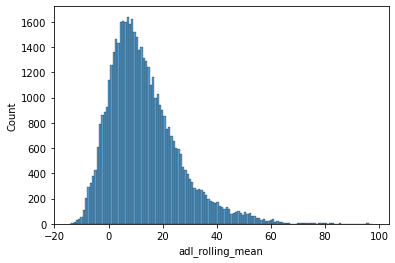

In [32]:
sns.histplot(y)

In [33]:
from scipy.stats import boxcox
from numpy import log

In [34]:
# splitting

from sklearn.model_selection import train_test_split

# x_train, x_test, y_train, y_test = train_test_split(X_scaled,y,train_size=0.7) #full scaled X
x_train, x_test, y_train, y_test = train_test_split(X,y,train_size=0.7)  #using partially scaled X
# x_train, x_test, y_train, y_test = train_test_split(X_scaled,y_,train_size=0.7) #full scaled X, boxcox y

In [35]:
from sklearn import metrics
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

In [ ]:
# gridsearch cv done from previous notebook

In [51]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

model = XGBRegressor(objective ='reg:squarederror',
                     booster='gbtree',
                     learning_rate = 0.1,
                     colsample_bytree = 1,
                     max_depth = 10, 
                     alpha = 10,
                     n_estimators = 100)
model.fit(x_train,y_train)

train_score = cross_val_score(model,x_train,y_train,cv=10)
print(round(train_score.mean(),2)*100)

79.0


In [52]:
y_pred = model.predict(x_test)

rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))
print(metrics.r2_score(y_test,y_pred))

RMSE: 5.666439
0.8110611741208832


In [50]:
from sklearn.feature_selection import SelectFromModel

# select features using threshold
selection = SelectFromModel(model, prefit=True)
select_X_train = selection.transform(x_train)
# train model
selection_model = XGBRegressor(objective ='reg:squarederror',
                    booster='gbtree',
                    learning_rate = 0.1,
                    max_depth = 10, 
                    alpha = 10,
                    n_estimators = 100)
selection_model.fit(select_X_train, y_train)

select_X_test = selection.transform(x_test)
y_pred = selection_model.predict(select_X_test)
print(metrics.r2_score(y_test,y_pred))

0.8571160639378641


In [40]:
from numpy import sort

In [44]:
thresholds = sort(model.feature_importances_)
for thresh in thresholds:
	# select features using threshold
	selection = SelectFromModel(model, threshold=thresh, prefit=True)
	select_X_train = selection.transform(x_train)
	# train model
	selection_model = XGBRegressor()
	selection_model.fit(select_X_train, y_train)
	# eval model
	select_X_test = selection.transform(x_test)
	predictions = selection_model.predict(select_X_test)
	accuracy = metrics.r2_score(y_test, predictions)
	print("Thresh=%.3f, n=%d, R2: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Thresh=0.000, n=39, R2: 73.01%
Thresh=0.000, n=39, R2: 73.01%
Thresh=0.000, n=39, R2: 73.01%
Thresh=0.000, n=39, R2: 73.01%
Thresh=0.002, n=35, R2: 72.81%
Thresh=0.003, n=34, R2: 72.81%
Thresh=0.005, n=33, R2: 73.40%
Thresh=0.005, n=32, R2: 74.61%
Thresh=0.005, n=31, R2: 74.33%
Thresh=0.005, n=30, R2: 73.93%
Thresh=0.005, n=29, R2: 75.87%
Thresh=0.006, n=28, R2: 76.02%
Thresh=0.006, n=27, R2: 75.09%
Thresh=0.006, n=26, R2: 73.73%
Thresh=0.006, n=25, R2: 73.96%
Thresh=0.006, n=24, R2: 75.28%
Thresh=0.006, n=23, R2: 73.77%
Thresh=0.006, n=22, R2: 75.11%
Thresh=0.006, n=21, R2: 76.54%
Thresh=0.007, n=20, R2: 77.58%
Thresh=0.007, n=19, R2: 76.24%
Thresh=0.007, n=18, R2: 77.59%
Thresh=0.007, n=17, R2: 77.12%
Thresh=0.007, n=16, R2: 77.83%
Thresh=0.007, n=15, R2: 77.71%
Thresh=0.008, n=14, R2: 77.28%
Thresh=0.008, n=13, R2: 77.64%
Thresh=0.009, n=12, R2: 78.86%
Thresh=0.009, n=11, R2: 77.66%
Thresh=0.009, n=10, R2: 78.99%
Thresh=0.010, n=9, R2: 79.19%
Thresh=0.024, n=8, R2: 78.86%
Thresh=0.0

In [46]:
model.feature_importances_

array([0.10006594, 0.00337156, 0.00478674, 0.00560654, 0.00452568,
       0.00736213, 0.0056342 , 0.13791321, 0.29252023, 0.        ,
       0.12116413, 0.00495526, 0.00497755, 0.00600208, 0.00912162,
       0.00950052, 0.00718653, 0.00684164, 0.00550489, 0.09001856,
       0.        , 0.        , 0.00562494, 0.00759582, 0.00682215,
       0.00597679, 0.00678566, 0.0068833 , 0.02421204, 0.00893182,
       0.00806492, 0.00570309, 0.03338799, 0.00557768, 0.03136462,
       0.0051959 , 0.00868018, 0.        , 0.00213405], dtype=float32)

In [47]:
from sklearn.metrics import mean_squared_error

testing_error = mean_squared_error(y_test,y_pred)
print(testing_error)

exp_var = metrics.explained_variance_score(y_test,y_pred)
print(exp_var)

24.281901719524836
0.857119212172445


In [48]:
cv_results = cross_validate(selection_model,X,y,cv=10,scoring='r2',n_jobs=-1)

print(cv_results['test_score'])

[0.74350957 0.76144356 0.77176194 0.76744731 0.75369528 0.74481514
 0.77447469 0.76355314 0.77271025 0.74565261]


In [ ]:
"""
ways to improve model 

-more weather data
    -wind speed, 
    -use all data - try iterative training using pickles (xgb)
    
-efficiency 
    -pipelines
"""